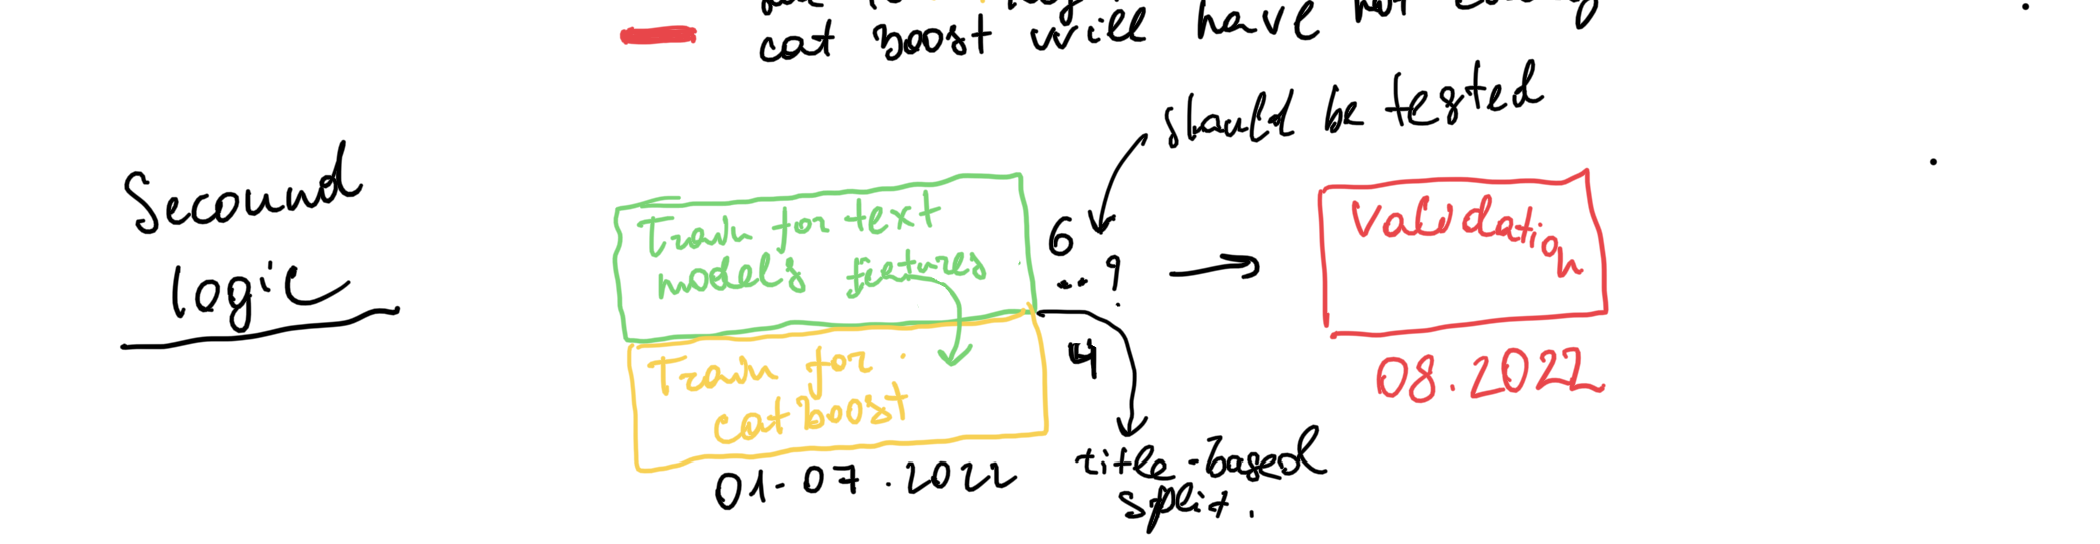

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import ast
import geoip2.database

cc_codes = ["fr"]
filename_pattern = "data/multilingual_train/{}_anonymous_text_07_2022_test_non_anon.csv"

In [2]:
#### regions_dict
# tmp_df = pd.read_csv("data/multilingual_train/processed_train_uk_de_pl_es_ru_en.csv")
# regions_dict_precalculated = {title: region for title, region in zip(tmp_df.page_title, tmp_df.page_region)}
regions_dict_precalculated = {}

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
class FeatureFactory:
    
    def __init__(self, 
        locations_db_path='GeoLite2-City.mmdb',
        text_ranking_split=0.6,
        regions_dict={}
    ):
        self.locations_db_path = locations_db_path
        self.text_ranking_split_rate = text_ranking_split
        self.regions_dict = regions_dict
        
    def text_ranking_split(self, data, stratify_col="page_title"):
        
        unique_titles = data[stratify_col].unique()
        n_unique_titles = len(unique_titles)
        text_titles = np.random.choice(unique_titles, 
                                       size=int(n_unique_titles*self.text_ranking_split_rate), 
                                       replace=False
                                      )
        data.loc[data[stratify_col].isin(text_titles), "is_text_train"] = 1
        data.loc[~data[stratify_col].isin(text_titles), "is_text_train"] = 0
        
        return data
    
    def balance_key(self, data, stratify_col="revision_is_identity_reverted"):
        
        part_1 = data[data[stratify_col] == 1]
        part_2 = data[data[stratify_col] == 0]
        part_2 = part_2.sample(np.min([len(part_1), len(part_2)]))
        balanced = pd.concat([part_1, part_2]).sample(len(part_1)+len(part_2))
        balanced_revision_id = set(balanced.revision_id)
        
        data.loc[data.revision_id.isin(balanced_revision_id), "is_balanced"] = 1
        data.loc[~data.revision_id.isin(balanced_revision_id), "is_balanced"] = 0
        
        return data
        
    def get_features(self, data, lang):
        data = self._get_all_pages_regions(data, lang)
        data = self._get_all_user_regions(data)
        return data
        
    def _get_all_pages_regions(self, data, lang, page_title_column="page_title"):
        regions = []
        for title in tqdm(data[page_title_column].unique()):
            if title in self.regions_dict:
                regions.append(self.regions_dict[title])
            else:
                regions.append(self._get_region_one(title, lang))
        regions_dict = {k: v for k, v in zip(data[page_title_column].unique(), regions)}
        data["page_region"] = data[page_title_column].apply(lambda x: regions_dict.get(x))
        data["page_region"] = data["page_region"].fillna("Unknown")
        return data
    
    def _get_all_user_regions(self, data, user_column="event_user_text_historical"):
        
        ips_features = []
        # This creates a Reader object. You should use the same object
        # across multiple requests as creation of it is expensive.
        with geoip2.database.Reader(self.locations_db_path) as reader:
            # Replace "city" with the method corresponding to the database
            # that you are using, e.g., "country".

            for ip in tqdm(data[user_column]):
                try:
                    response = reader.city(ip)
                    ips_features.append([response.country.iso_code, 
                                         response.subdivisions.most_specific.iso_code,
                                         response.city.name,
                                         response.location.latitude, 
                                         response.location.longitude])
                except:
                    ips_features.append([None, None, None, None, None])

        columns = ["country_iso_code", "region_iso_code", "city", "latitude", "longitude"]

        anon_user_features = pd.DataFrame(ips_features, columns=columns)
        anon_user_features["revision_id"] = data["revision_id"].values
        data = data \
            .merge(anon_user_features, how='left', left_on="revision_id", right_on="revision_id")
        return data
    
    @staticmethod
    def _get_region_one(title, lang):
        try:
            query = f"https://wiki-region.wmcloud.org/api/v1/region?lang={lang}&titles="
            res = requests.get(query + title).json()
        except:
            return None

        if len(res)>0 and res[0].get("regions") and len(res[0]["regions"])>0:
            return res[0]["regions"][0]["region"]
        else:
            return None   

In [ ]:
validation_timestamp_split = "2022-07-01"
feature_factory = FeatureFactory()

train_dfs = []
test_dfs = []

for cc in cc_codes:
#     tmp_df = pd.read_csv(filename_pattern.format(cc))
#     tmp_df = feature_factory.get_features(tmp_df, cc)
    
#     train_df = tmp_df[tmp_df.event_timestamp < validation_timestamp_split] \
#         .reset_index(drop=True)
#     train_df = feature_factory.balance_key(train_df)
#     train_df = feature_factory.text_ranking_split(train_df)
#     train_dfs.append(train_df)
    
    # test_df = tmp_df[tmp_df.event_timestamp >= validation_timestamp_split] \
    #     .reset_index(drop=True)
    
    test_df = feature_factory.balance_key(test_df)
    test_dfs.append(test_df)
                    
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

 17%|█▋        | 8363/49702 [14:34<1:00:23, 11.41it/s]

In [ ]:
# filename_pattern_train = "data/multilingual_train/train_{}.csv".format("_".join(cc_codes))
filename_pattern_test = "data/multilingual_train/test_{}.csv".format("_".join(cc_codes))

# train_df.to_csv(filename_pattern_train, index=False)
test_df.to_csv(filename_pattern_test, index=False)

# Calculating all features: 



In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import ast
import geoip2.database

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from transformers import AutoTokenizer, BertForSequenceClassification
from transformers import pipeline
import gc

from scipy.special import softmax


CONTENT_TYPES = [
 'Argument', 'Category', 'Comment', 'ExternalLink',
 'Gallery', 'HTMLEntity', 'Heading', 'List', 'Media',
 'Paragraph', 'Punctuation', 'Reference', 'Section',
 'Sentence', 'Table', 'Table Element', 'Template',
 'Text', 'Text Formatting', 'Whitespace', 'Wikilink', 'Word'
]

ACTION_TYPES = ['change', 'insert', 'move', 'remove']

insert_model = "insert_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-85380"
insert_default_values = [-1, -1, -1, -1, -1, -1, -1, -1]
change_model = "insert_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-173735"
change_default_values = [-1, -1, -1, -1, -1, -1, -1, -1]
title_model = "title_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-19270"
title_default_values = [-1, -1]
comment_model = "comment_bert-base-multilingual-cased-finetuned-multi_balanced/checkpoint-246445"
comment_default_values = [-1, -1, -1, -1]


class FeatureExtractor:
    ## todo: Add function to return column (feature names)
    
    def __init__(
        self, 
        content_types=CONTENT_TYPES, 
        action_types=ACTION_TYPES,
        insert_model=insert_model,
        insert_default_values=insert_default_values,
        change_model = change_model,
        change_default_values = change_default_values,
        title_model = title_model,
        title_default_values = title_default_values,
        comment_model = comment_model,
        comment_default_values = comment_default_values,
    ):
        self.content_types = content_types
        self.action_types = action_types
        self.insert_model = insert_model
        self.insert_default_values = insert_default_values
        self.change_model = change_model
        self.change_default_values = change_default_values
        self.title_model = title_model
        self.title_default_values = title_default_values
        self.comment_model = comment_model
        self.comment_default_values = comment_default_values
    
    def get_features(self, df):
        df = df.reset_index(drop=True)
        df = self._get_actions_features(df)
        df = self._get_insert_text_features(df)
        df = self._get_change_text_features(df)
        df = self._get_title_semantics(df)
        df = self._get_comment_semantics(df)
        
        return df
    
    def _get_actions_features(self, df, actions_column = "actions"):
        features = []
        feature_names = [f"{t}_{c}" for t in self.content_types for c in self.action_types]
        for actions in tqdm(df[actions_column]):
            actions = ast.literal_eval(actions)
            features_tmp = [actions.get(t, {}).get(c, 0) for t in self.content_types for c in self.action_types]
            features.append(features_tmp)
        features_df = pd.DataFrame(features, columns=feature_names)
        for c in feature_names:
            df[c] = features_df[c].values
        return df
    
    def _get_insert_text_features(self, df):
        print("Processing inserts....")
        print("Preparing texts: ")
        texts_to_process = self._get_text_to_process(df, "texts_insert")
        print("Preparing features: ")
        texts_mapping = self._get_text_features(texts_to_process, model_type="insert")
        print("Mapping features: ")
        text_features = []
        for texts_raw in tqdm(df.texts_insert):
            texts = ast.literal_eval(texts_raw).get("Text", [])
            features_local = [texts_mapping.get(text) for text in texts if not texts_mapping.get(text) is None]
            if len(features_local) == 0:
                text_features.append(self.insert_default_values)
            else:
                text_features.append(np.hstack([np.max(features_local, axis=0), np.mean(features_local, axis=0)]))
        
        text_features = np.array(text_features)
        p_columns = [f"insert_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
        for i, c in enumerate(p_columns):
            df[c] = text_features[:, i]
        return df
    
    def _get_change_text_features(self, df):
        print("Processing changes....")
        print("Preparing texts: ")
        texts_to_process = self._get_text_to_process(df, "texts_change")
        print("Preparing features: ")
        texts_mapping = self._get_text_features(texts_to_process, model_type="change")
        print("Mapping features: ")
        text_features = []
        for texts_raw in tqdm(df.texts_change):
            texts = ast.literal_eval(texts_raw).get("Text", [])
            features_local = [texts_mapping.get(str({"text": text[0], "text_pair": text[1]})) for text in texts 
                              if not texts_mapping.get(str({"text": text[0], "text_pair": text[1]})) is None]
            if len(features_local) == 0:
                text_features.append(self.change_default_values)
            else:
                text_features.append(np.hstack([np.max(features_local, axis=0), np.mean(features_local, axis=0)]))
        
        text_features = np.array(text_features)
        p_columns = [f"change_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
        for i, c in enumerate(p_columns):
            df[c] = text_features[:, i]
        return df
    
    def _get_title_semantics(self, df):
        print("Processing title....")
        print("Preparing texts: ")
        texts_to_process = self._get_text_to_process(df, "page_title")
        print("Preparing features: ")
        texts_mapping = self._get_text_features(texts_to_process, model_type="title")
        print("Mapping features: ")
        text_features = []
        for texts_raw in tqdm(df.page_title):
            features_local = texts_mapping.get(texts_raw)
            if features_local is None:
                text_features.append(self.title_default_values)
            else:
                text_features.append(features_local)
        
        text_features = np.array(text_features)
        p_columns = [f"title_{c}" for c in ["s_0", "p_0"]]
        for i, c in enumerate(p_columns):
            df[c] = text_features[:, i]
        return df
    
    def _get_comment_semantics(self, df):
        print("Processing comments....")
        print("Preparing texts: ")
        texts_to_process = self._get_text_to_process(df, "event_comment")
        print("Preparing features: ")
        texts_mapping = self._get_text_features(texts_to_process, model_type="comment")
        print("Mapping features: ")
        text_features = []
        for texts_raw in tqdm(df.event_comment):
            features_local = texts_mapping.get(texts_raw)
            if features_local is None:
                text_features.append(self.comment_default_values)
            else:
                text_features.append(features_local)
        
        text_features = np.array(text_features)
        p_columns = [f"comment_{c}" for c in ["s_0", "s_1", "p_0", "p_1"]]
        for i, c in enumerate(p_columns):
            df[c] = text_features[:, i]
        return df

    def _preds_processing(self, preds):
        res = []
        for i in preds:
            res.append(i['score'])
        return np.hstack([res, softmax(res)])
    
    def _get_text_to_process(self, df, field_name):
        texts_to_process = []
        if field_name in ["page_title", "event_comment"]:
            return list(df[field_name].dropna().unique())
        else:
            for texts_raw in df[field_name].unique():
                texts = ast.literal_eval(texts_raw).get("Text", [])
                if field_name == "texts_insert" and len(texts) > 0:
                    texts_to_process += [text for text in texts if len(text) > 0]
                elif field_name == "texts_change" and len(texts) > 0:
                    texts_to_process += [{"text": text[0], "text_pair": text[1]} for text in texts if text[0] != text[1]]
                else:
                    pass
            return texts_to_process
    
    def _get_text_features(self, texts, model_type="insert"):
        
        print("Loading models: ")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        tqdm_batch_size = 1000
        print(f"Selected {device}")
        
        if model_type == "insert":
            tokenizer = AutoTokenizer.from_pretrained(self.insert_model, truncation=True,  max_length=512, device=device)
            model = BertForSequenceClassification.from_pretrained(self.insert_model).to(device)
        elif model_type == "change":
            tokenizer = AutoTokenizer.from_pretrained(self.change_model, truncation=True,  max_length=512, device=device)
            model = BertForSequenceClassification.from_pretrained(self.change_model).to(device)
        elif model_type == "comment":
            tokenizer = AutoTokenizer.from_pretrained(self.comment_model, truncation=True,  max_length=512, device=device)
            model = BertForSequenceClassification.from_pretrained(self.comment_model).to(device)
        elif model_type == "title":
            tokenizer = AutoTokenizer.from_pretrained(self.title_model, truncation=True,  max_length=512, device=device)
            model = BertForSequenceClassification.from_pretrained(self.title_model).to(device)
        else:
            raise NotImplementedError
        
        clf = pipeline(task="text-classification", model=model, tokenizer=tokenizer, device=0, batch_size=124)

        print(f"Predicting {len(texts)} texts: ")
        tokenizer_kwargs = {'truncation':True, 'max_length':512}

        preds = []
        for i in tqdm(range(0, len(texts), tqdm_batch_size)):
            preds += clf(texts[i:i+tqdm_batch_size], return_all_scores=True, function_to_apply="none", **tokenizer_kwargs, batch_size=64)

        del tokenizer, model
        gc.collect()
        torch.cuda.empty_cache()

        print("Postprocessing: ")
        parser_preds = [self._preds_processing(p) for p in preds]
        preds_dict = {str(k): v for k, v in zip(texts, parser_preds)}
        
        return preds_dict

In [ ]:
feature_extractor = FeatureExtractor()
# train_df = feature_extractor.get_features(train_df)
test_df = feature_extractor.get_features(test_df)

In [ ]:
# filename_pattern_train = "data/multilingual_train/train_{}.csv".format("_".join(cc_codes))
filename_pattern_test = "data/multilingual_train/test_full_week_{}_non_anon_processed.csv".format("_".join(cc_codes))
test_df.to_csv(filename_pattern_test, index=False)

In [12]:
test_df

,wiki_db,event_comment,event_user_text_historical,event_user_seconds_since_previous_revision,revision_id,page_title,page_revision_count,revision_text_bytes_diff,revision_is_identity_reverted,event_timestamp,...,change_s_0_mean,change_s_1_mean,change_p_0_mean,change_p_1_mean,title_s_0,title_p_0,comment_s_0,comment_s_1,comment_p_0,comment_p_1
0,frwiki,/* Élections législatives */,GeminiVirgo13,39765.0,194975776,Nouvelle_Union_populaire_écologique_et_sociale,1351,11,0,2022-07-01 00:11:00.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.293606,1.0,0.014682,-0.198847,0.55318,0.44682
1,frwiki,Terminus temporaire pour cause de travaux.,NB80,1678.0,194976334,Gare_des_Aubrais,506,-25,0,2022-07-01 01:01:05.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.218968,1.0,0.014682,-0.198847,0.55318,0.44682
2,frwiki,/* Distribution */,S0undwave,24731.0,194976613,Le_diable_s'habille_en_Prada_(film),453,75,0,2022-07-01 01:32:56.0,...,0.012096,0.009650,0.500042,0.499958,0.883708,1.0,0.014682,-0.198847,0.55318,0.44682
3,frwiki,/* Dérèglement climatique */ explication du no...,PierrotdePont,132.0,194978459,Mathilde_Panot,284,82,0,2022-07-01 05:26:45.0,...,2.615768,-2.520922,0.994157,0.005843,0.361233,1.0,0.014682,-0.198847,0.55318,0.44682
4,frwiki,/* Géographie */,Ccmpg,24.0,194978744,La_Rochette-du-Buis,167,-1316,0,2022-07-01 05:39:20.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.853149,1.0,0.014682,-0.198847,0.55318,0.44682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114314,frwiki,/* Train d'atterrissage */ typo.,Couleys,8813.0,195148022,Iliouchine_Il-62,312,-1,0,2022-07-07 19:22:30.0,...,2.499558,-2.389590,0.992528,0.007472,0.646023,1.0,0.014682,-0.198847,0.55318,0.44682
114315,frwiki,NaN,CS81,252.0,195149217,Effectif_actuel_des_Sénateurs_d'Ottawa,236,108,0,2022-07-07 20:20:19.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.043918,1.0,-1.000000,-1.000000,-1.00000,-1.00000
114316,frwiki,/* Carrière en club */,Khalil Le Rajaoui,169.0,195151256,Imane_Saoud,58,183,0,2022-07-07 21:34:45.0,...,2.102327,-1.797005,0.980147,0.019853,0.883419,1.0,0.014682,-0.198847,0.55318,0.44682
114317,frwiki,NaN,WikipSQ,907.0,195151263,Mouille_(hydrologie),23,678,0,2022-07-07 21:34:59.0,...,-2.564955,2.373668,0.007113,0.992887,0.836177,1.0,-1.000000,-1.000000,-1.00000,-1.00000
